In [1]:
import numpy as np
import scipy.signal
from scipy.optimize import minimize
import pandas as pd
pd.set_option('max_columns', None)
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
from fur.one_data_set_analyzer import analyze_one_dataset
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data, get_acnet_df_with_bunch_sizes
shift = path_assistant.PathAssistant('shift_03_16_2020',
    ignore_files=['RefCurve_2020-03-16_0_084020_test.Wfm.bin',
                  'RefCurve_2020-03-16_153_155200.Wfm.bin'])
#shift_03_09_2020.show_waveform_file_names()
waveforms_dir = shift.get_waveforms_dir()
results_dir = shift.get_results_dir()
from config import get_from_config, save_to_config
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
import lattice.lattice as lattice

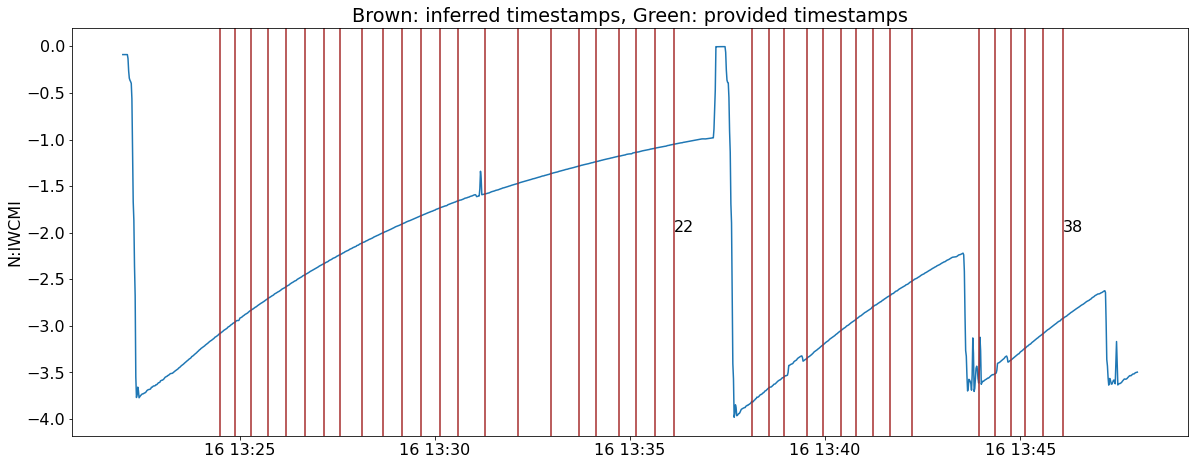

/home/ilobach/fur/env/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ilobach/fur/lattice/lattice.py:131: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(e_um*1e4*beta_cm+(1e4*dispersion_cm*dpp)**2)
/home/ilobach/fur/env/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [2]:
res_df_FLAT = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_FLAT_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt",
    'all_acnet_data_FLAT_case_03_16_2020.csv',
    show_plot=True
)
acnted_df_FLAT = shift.get_acnet_data_df('all_acnet_data_FLAT_case_03_16_2020.csv')
res_df_ROUND = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_ROUND_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt",
    'all_acnet_data_ROUND_case_03_16_2020.csv'
)
acnted_df_ROUND = shift.get_acnet_data_df('all_acnet_data_ROUND_case_03_16_2020.csv')
res_df_ROUND_Low_RF = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_ROUND_LONG_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"
)
acnted_df_ROUND_Low_RF = shift.get_acnet_data_df('all_acnet_data_ROUND_low_RF_case_03_16_2020.csv')

In [3]:
rdt = res_df_FLAT['real_datetime']
time_intervals = [(rdt[0], rdt[22]), (rdt[23], rdt[32]), (rdt[33], rdt[38])]
def in_time_intervals(row):
    t = row.name
    return True in [(t>ti[0] and t<ti[1]) for ti in time_intervals]
time_intervals

[(Timestamp('2020-03-16 13:24:29'), Timestamp('2020-03-16 13:36:07')),
 (Timestamp('2020-03-16 13:38:08'), Timestamp('2020-03-16 13:42:13')),
 (Timestamp('2020-03-16 13:43:56'), Timestamp('2020-03-16 13:46:05'))]

In [4]:
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")

In [5]:
sum_channel_to_photoelectrons = get_from_config('sum_channel_to_photoelectrons')

In [6]:
Mfunc, Mxder, Myder, Mzder, Meder = get_M_interpolator_at_fixed_energy()

In [7]:
size_names = ['Sigma_um_X', 'Sigma_um_Y', 'N:IWCMBE']
def var_theor(x, M):
    return x+1/M*x**2

In [8]:
for fluctuations_df in [res_df_FLAT, res_df_ROUND, res_df_ROUND_Low_RF]:
    N = sum_channel_to_photoelectrons*fluctuations_df["ch2_amplitude"].values
    varN = 2*sum_channel_to_photoelectrons**2*fluctuations_df["var_of_ch1_amplitude"].values
    fluctuations_df['N'] = N
    fluctuations_df['varN'] = varN
    fluctuations_df['varN_theor'] = fluctuations_df.apply(lambda row: var_theor(row['N'],Mfunc(row['Sigma_um_X'], row['Sigma_um_Y'], row['N:IWCMBE'])),axis=1) 

In [9]:
# plt.plot(res_df_FLAT["ch2_amplitude"],res_df_FLAT["var_of_ch1_amplitude"] ,'.', label="FLAT")
# plt.plot(res_df_ROUND["ch2_amplitude"],res_df_ROUND["var_of_ch1_amplitude"] ,'.', label="ROUND")
# plt.plot(res_df_ROUND_Low_RF["ch2_amplitude"],res_df_ROUND_Low_RF["var_of_ch1_amplitude"] ,'.', label="ROUND_LONG")
# x_f = np.linspace(0,max(res_df_FLAT["ch2_amplitude"]),1000)
# plt.xlabel("Sum channel amplitude, V")
# plt.ylabel("Variance of the difference channel amplitude, V$^2$")
# plt.title(r"Shift 03-16-2020")
# plt.legend()
# plt.savefig(results_dir.fi("no_nd_filters_variable_beam_current.png"), bbox_inches='tight')
# plt.show()

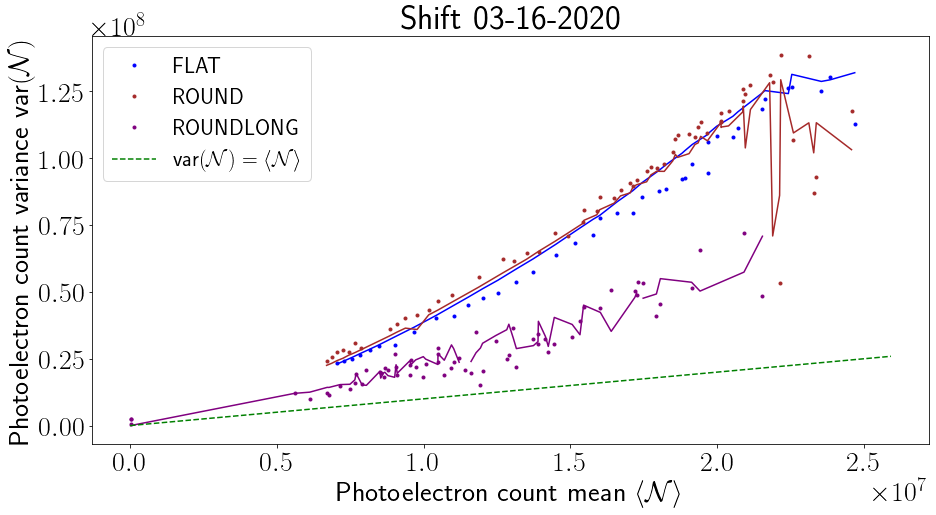

In [10]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
colors = {"FLAT": 'blue', "ROUND": 'brown', "ROUNDLONG": 'purple'}
data_sets = {'FLAT': res_df_FLAT, 'ROUND': res_df_ROUND ,'ROUNDLONG': res_df_ROUND_Low_RF}
fig, ax = plt.subplots(figsize=(15, 7.5))
for name, df in data_sets.items():
    ax.plot(
        df["N"],
        df["varN"],
        '.', label=name, color=colors[name])
    df_N_sorted = df.sort_values('N')
    ax.plot(
        df_N_sorted["N"],
        df_N_sorted["varN_theor"]
        ,'-', color=colors[name])
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax.set_title(r"Shift 03-16-2020")
ax.legend()
plt.show()

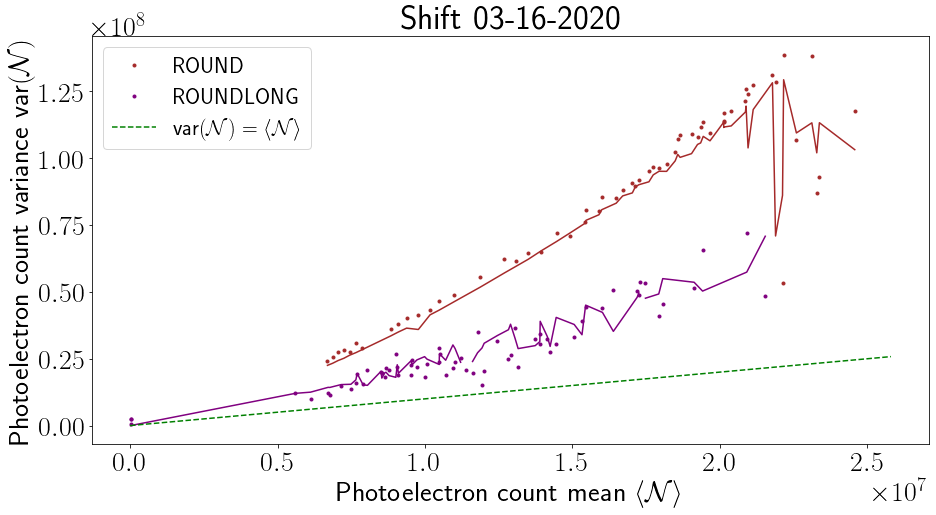

In [11]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
colors = {"ROUND": 'brown', "ROUNDLONG": 'purple'}
data_sets = {'ROUND': res_df_ROUND ,'ROUNDLONG': res_df_ROUND_Low_RF}
fig, ax = plt.subplots(figsize=(15, 7.5))
for name, df in data_sets.items():
    ax.plot(
        df["N"],
        df["varN"],
        '.', label=name, color=colors[name])
    df_N_sorted = df.sort_values('N')
    ax.plot(
        df_N_sorted["N"],
        df_N_sorted["varN_theor"]
        ,'-', color=colors[name])
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax.set_title(r"Shift 03-16-2020")
ax.legend()
plt.show()

In [12]:
# acnet_df_FLAT_with_bunch_sizes = get_acnet_df_with_bunch_sizes(
#     shift,
#     "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt",
#     acnted_df_FLAT
# )

In [13]:
# acnet_df_FLAT_with_bunch_sizes.to_csv(shift.get_acnet_data_dir().fi('all_acnet_data_with_bunch_sizes_FLAT_case_03_16_2020.csv'))

In [14]:
acnet_df_FLAT_with_bunch_sizes = pd.read_csv(shift.get_acnet_data_dir().fi('all_acnet_data_with_bunch_sizes_FLAT_case_03_16_2020.csv'), index_col=0, parse_dates=True)
acnet_df_FLAT_with_bunch_sizes_in_time_intervals = acnet_df_FLAT_with_bunch_sizes[acnet_df_FLAT_with_bunch_sizes.apply(in_time_intervals, axis=1).values]

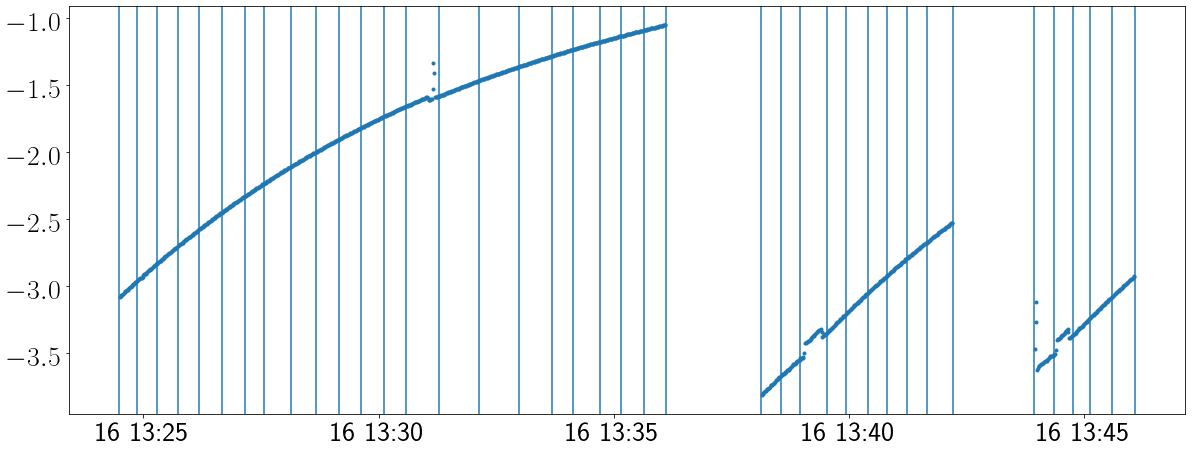

In [15]:
df = acnet_df_FLAT_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
ax.plot(df.index, df['N:IWCMI'],'.')
for t in res_df_FLAT['real_datetime']:
    ax.axvline(t)
plt.show()

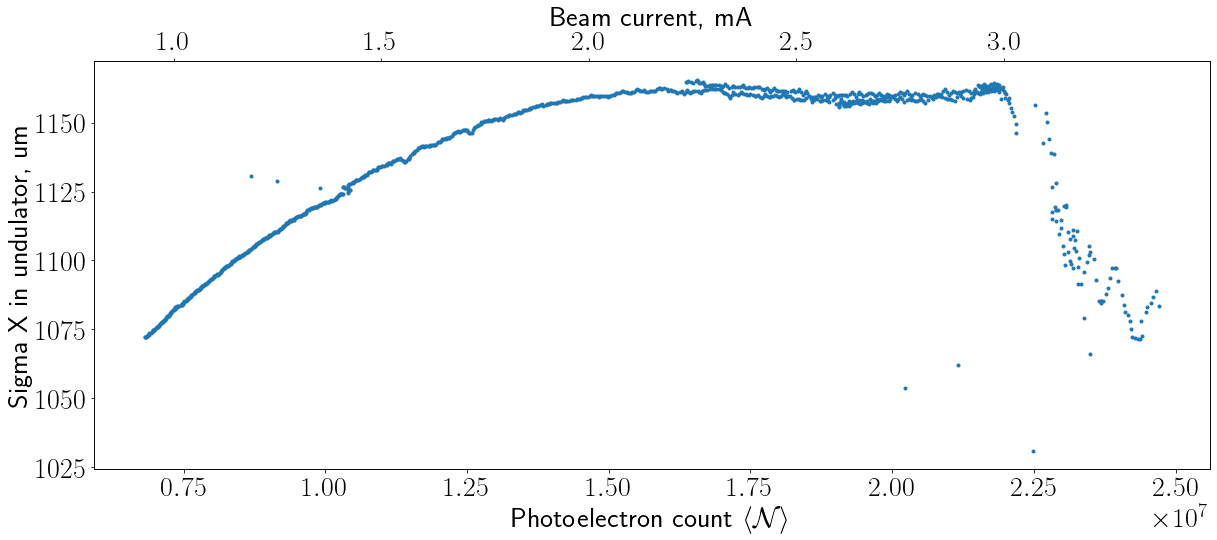

In [16]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
df = acnet_df_FLAT_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_X'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma X in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

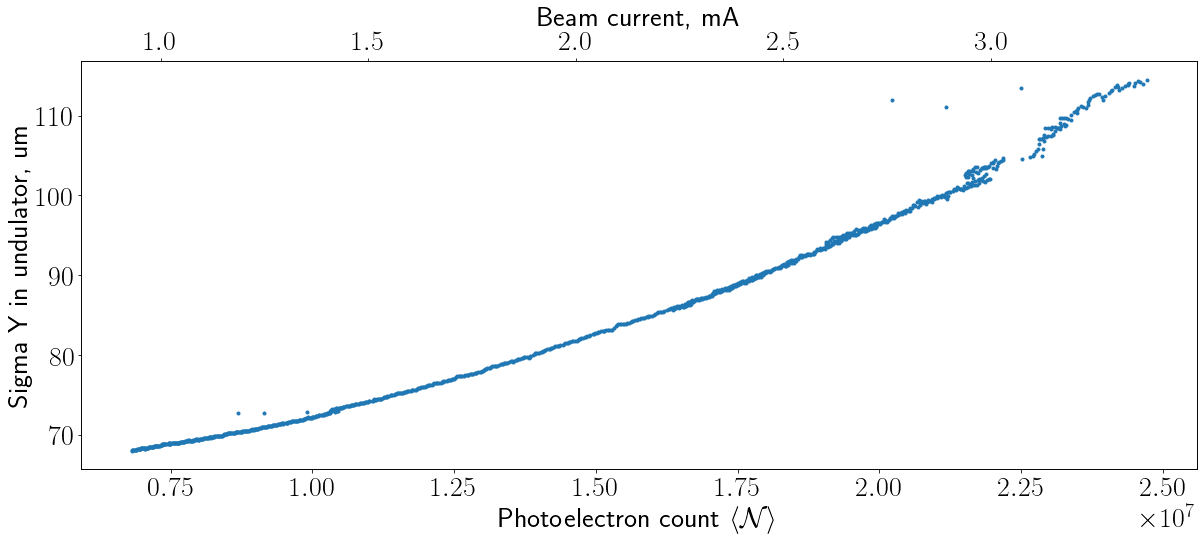

In [17]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
df = acnet_df_FLAT_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_Y'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma Y in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

# Leaving only first injection:

In [18]:
first_injection = acnet_df_FLAT_with_bunch_sizes_in_time_intervals[
    acnet_df_FLAT_with_bunch_sizes_in_time_intervals.index<time_intervals[0][1]]
df = first_injection

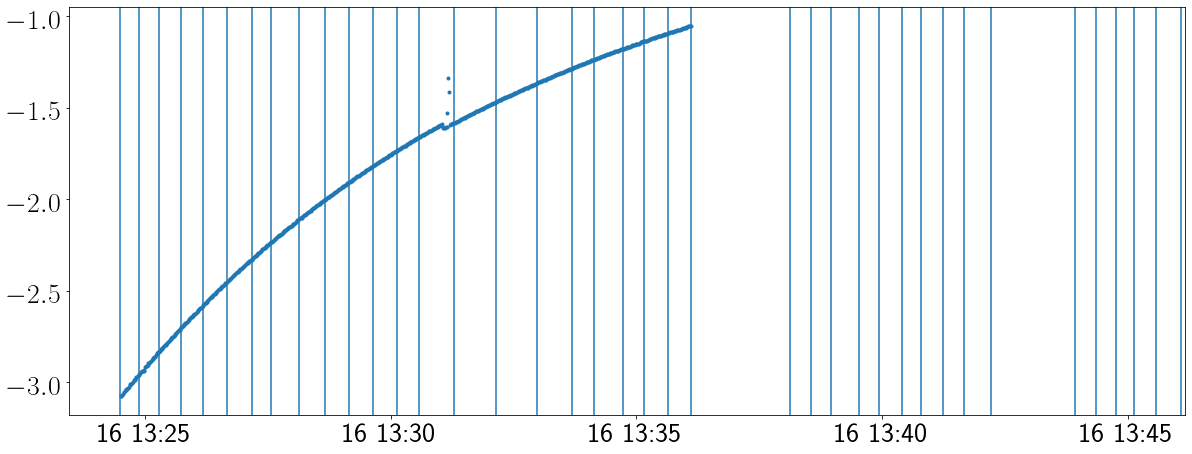

In [19]:
df = first_injection
fig, ax = plt.subplots()
ax.plot(df.index, df['N:IWCMI'],'.')
for t in res_df_FLAT['real_datetime']:
    ax.axvline(t)
plt.show()

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


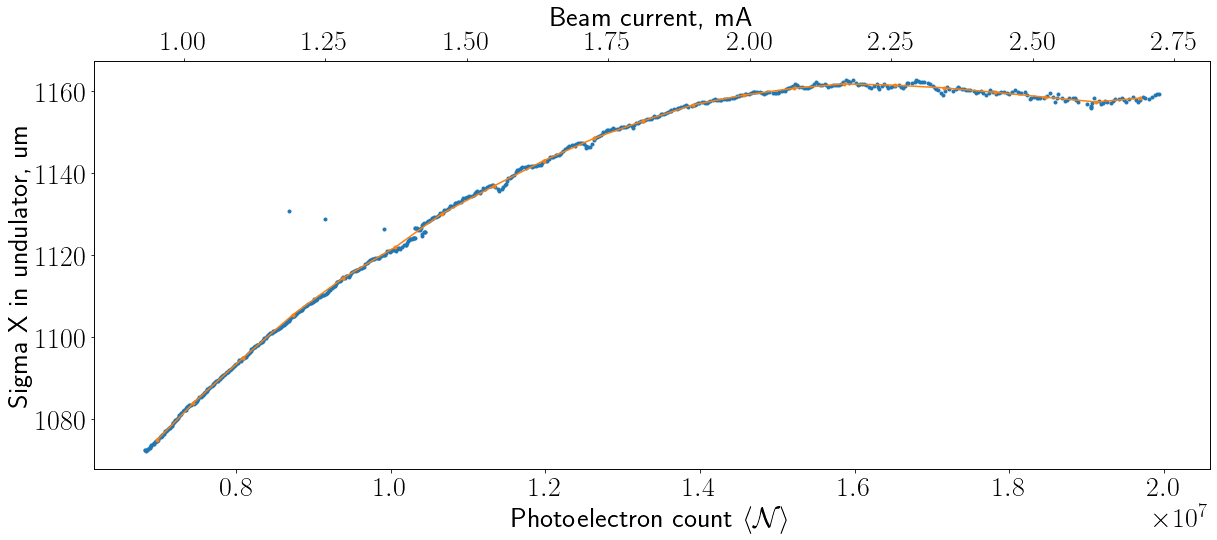

In [20]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_X'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma X in undulator, um")
ax1 = ax.twiny()
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
sx_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['Sigma_um_X'], bounds_error=False, fill_value="extrapolate")
sx_interp = sx_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sx_err_stat = np.std(first_injection['Sigma_um_X'].values-sx_interp)
ax.plot(photoel, df['Sigma_um_X'],'.-')
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [21]:
sx_err_stat

1.3163820525119132

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


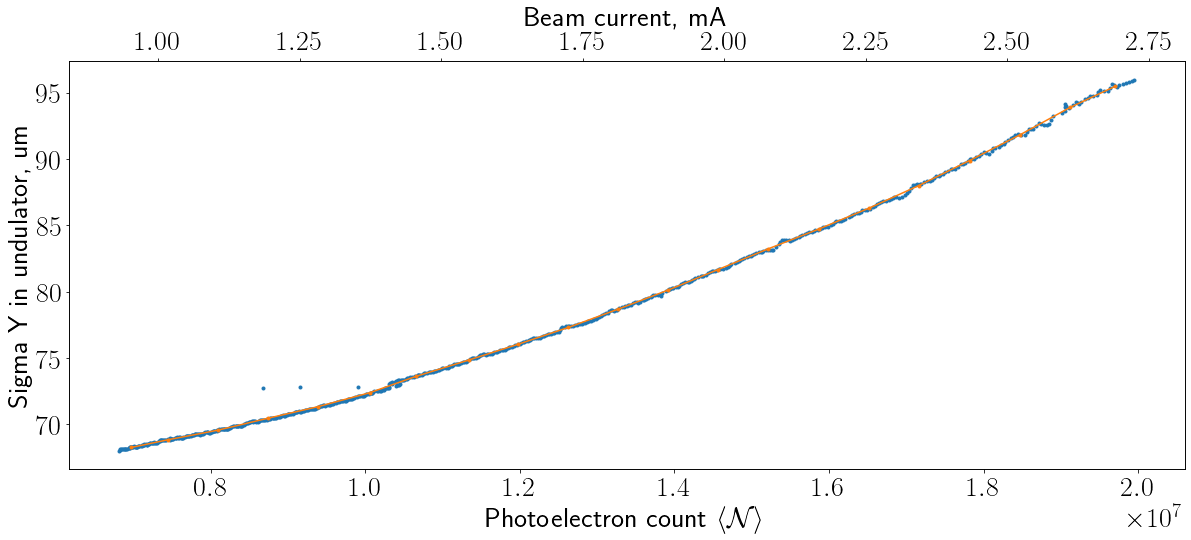

In [22]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots()
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_Y'],'.')
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
sy_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['Sigma_um_Y'], bounds_error=False, fill_value="extrapolate")
sy_interp = sy_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sy_err_stat = np.std(first_injection['Sigma_um_Y'].values-sy_interp)
ax.plot(photoel, df['Sigma_um_Y'],'.-')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma Y in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [23]:
sy_err_stat

0.13986360966244632

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


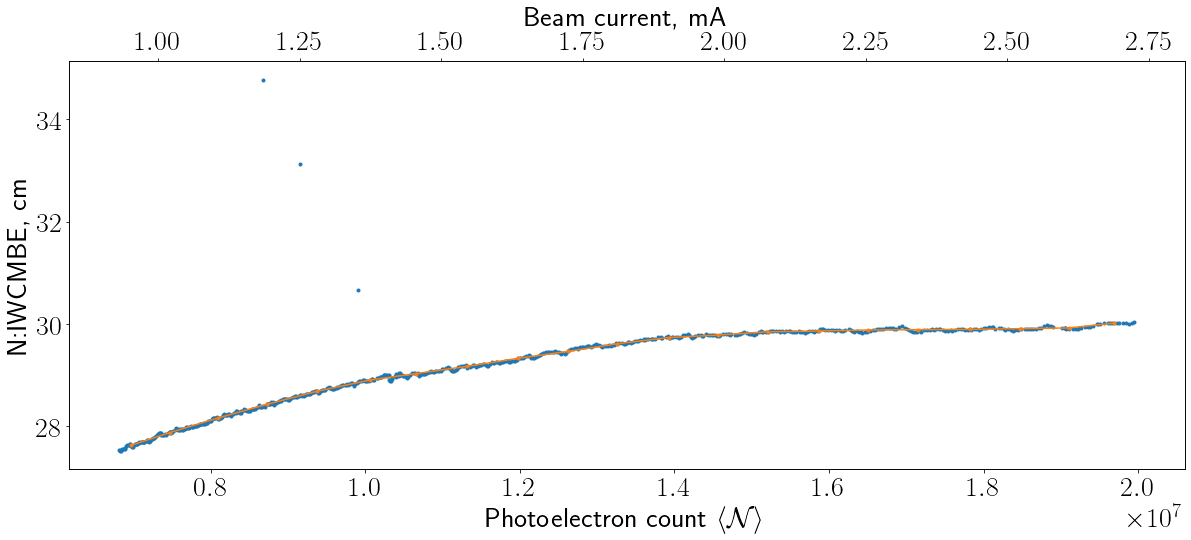

In [24]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots()
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['N:IWCMBE'],'.')
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').median()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
sz_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['N:IWCMBE'], bounds_error=False, fill_value="extrapolate")
sz_interp = sz_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sz_err_stat = 1.4826*np.mean(np.absolute(first_injection['N:IWCMBE'].values-sz_interp))
ax.plot(photoel, df['N:IWCMBE'],'.-')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("N:IWCMBE, cm")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [25]:
sz_err_stat

0.054086674993107174

In [26]:
df_desc = df.describe()
df_desc

,N:ITC1RSV,N:ITC1RSH,N:ITC2RSV,N:ITC2RSH,N:ITC3RSV,N:ITC3RSH,N:ITC4RSV,N:ITC4RSH,N:ITC4LSV,N:ITC4LSH,N:ITC3LSV,N:ITC3LSH,N:ITC2LSV,N:ITC2LSH,N:ITC1LSV,N:ITC1LSH,N:IWCMBF,N:IWCMBR,N:IWCMBP,N:IWCMI,N:IRFEPA,N:IRFEPP,N:IWCMBE,N:IWCMBM,N:IWCMBG,N:IWCMIG,N:IBEAMA,N:IRFEPC,N:IRFEAT,N:IRFEFP,N:IRFECG,N:IWCMI_recalibrated_to_IWCMI_absolute,N:IBEAM_recalibrated_to_IWCMI_absolute,Sigma_um_X,Sigma_um_X_err,Sigma_um_Y,Sigma_um_Y_err,Angle_spread_rad_X,Angle_spread_rad_Y,ex_um,ex_err,ey_um,ey_err,dp/p,dp/p_err
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.0000,2.100000e+01,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.0,2.100000e+01,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.0
mean,97.298762,457.120738,78.079740,1382.917914,88.980545,1598.106780,105.9989,7.327710e+02,145.112038,1050.883184,65.476182,1609.192731,67.211798,1516.756371,114.084327,495.085328,62.774646,31.823855,-84.022319,-2.050215,358.432839,102.173180,29.289318,24.187357,27.728666,-1.994575,-1.882765,42.5,-8.800000e+00,8.456483,0.260102,-1.813547,-1.820139,1138.046887,18.363339,79.836409,8.022517,0.000868,0.000108,0.598779,0.020537,0.006550,0.001296,0.000273,0.0
std,13.400091,11.285032,2.917727,32.514047,6.415611,39.303032,0.0000,1.164943e-13,13.084309,26.736194,7.425421,41.675211,3.584001,37.065318,16.755270,12.235037,1.931219,0.682561,0.129102,0.617675,0.434705,0.189493,0.739715,0.579078,0.774336,0.604030,0.555256,0.0,1.820224e-15,0.021681,0.000350,0.546373,0.536786,28.029938,0.397672,8.683774,0.361999,0.000022,0.000012,0.029331,0.000919,0.001435,0.000083,0.000006,0.0
min,79.549194,431.461500,74.217598,1309.385000,80.519447,1509.776000,105.9989,7.327710e+02,128.019445,991.261960,55.664499,1514.897900,62.517902,1433.073000,91.259201,467.048800,59.056236,30.288105,-84.215404,-3.040282,357.727167,101.868060,27.633382,22.897075,26.072638,-2.963459,-2.760000,42.5,-8.800000e+00,8.420000,0.259500,-2.689325,-2.668194,1074.663067,17.545747,68.261529,7.403124,0.000819,0.000092,0.533312,0.018518,0.004735,0.001186,0.000260,0.0
25%,85.689373,450.501138,75.766495,1364.267000,83.609347,1574.443500,105.9989,7.327710e+02,133.916225,1034.483000,59.066148,1584.230075,64.263925,1495.077500,99.537075,488.324872,61.321666,31.404535,-84.135143,-2.549113,358.100858,102.011940,28.906896,23.858276,27.316183,-2.483332,-2.329869,42.5,-8.800000e+00,8.440000,0.259800,-2.254854,-2.252371,1121.339030,18.182461,72.369608,7.798183,0.000855,0.000098,0.580941,0.020038,0.005322,0.001230,0.000270,0.0
50%,95.487404,462.700447,77.423103,1398.062950,87.714203,1617.452000,105.9989,7.327710e+02,142.833300,1065.542000,64.306297,1632.854000,66.427101,1534.517900,112.635500,499.912840,63.454967,32.133214,-84.027895,-2.046757,358.471526,102.183795,29.613837,24.430900,28.018900,-1.989251,-1.890245,42.5,-8.800000e+00,8.460000,0.260200,-1.810488,-1.827370,1152.608991,18.351560,78.639037,7.942148,0.000879,0.000106,0.614126,0.020758,0.006284,0.001270,0.000276,0.0
75%,107.259375,465.298800,80.247429,1408.912275,93.887653,1628.279500,105.9989,7.327710e+02,155.041918,1070.881000,71.121397,1639.585750,69.901625,1545.453500,125.851847,503.353000,64.330017,32.329394,-83.913137,-1.553703,358.730155,102.330540,29.883659,24.663118,28.359549,-1.510900,-1.429247,42.5,-8.800000e+00,8.470000,0.260300,-1.374350,-1.381706,1159.255272,18.707346,86.215264,8.372456,0.000884,0.000116,0.621285,0.021336,0.007553,0.001371,0.000278,0.0
max,121.390350,467.668490,83.522400,1409.936750,100.575345,1631.142025,105.9989,7.327710e+02,168.792250,1074.535475,78.749202,1646.241025,73.807850,1548.092775,144.493905,507.441748,65.260960,32.448689,-83.825655,-1.076718,359.146881,102.450778,30.017486,24.758307,28.565827,-1.045978,-0.998724,42.5,-8.800000e+00,8.491922,0.260638,-0.952426,

In [27]:
hybrid_balance_error = get_from_config("HybridBalanceError")
fit_errorbar = get_from_config("varN_error_fit")

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


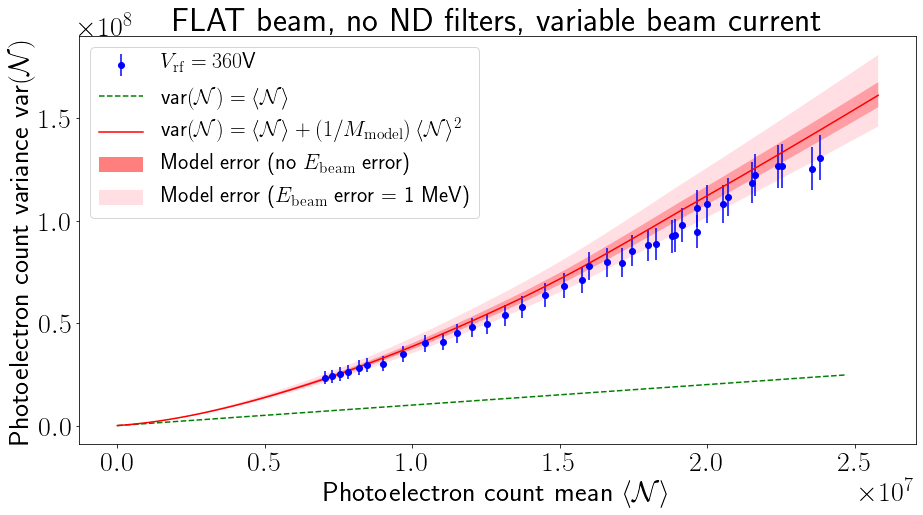

In [28]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
colors = {"FLAT": 'blue', "FLATLONG": 'purple'}
data_sets = {
    'FLAT': res_df_FLAT}

theor_df = pd.DataFrame({"N": x_aux})
theor_df['sx'] = sx_func(theor_df['N'])
theor_df['sy'] = sy_func(theor_df['N'])
theor_df['sz'] = sz_func(theor_df['N'])
theor_df['sx_err_stat'] = sx_err_stat
theor_df['sy_err_stat'] = sy_err_stat
theor_df['sz_err_stat'] = sz_err_stat
theor_df['sx_err_sm'] = df_desc.loc['mean', 'Sigma_um_X_err']
theor_df['sy_err_sm'] = df_desc.loc['mean', 'Sigma_um_Y_err']
theor_df['sz_err_sm'] = 0
theor_df['sx_err_tot'] = np.sqrt(theor_df['sx_err_stat']**2+theor_df['sx_err_sm']**2)
theor_df['sy_err_tot'] = np.sqrt(theor_df['sy_err_stat']**2+theor_df['sy_err_sm']**2)
theor_df['sz_err_tot'] = np.sqrt(theor_df['sz_err_stat']**2+theor_df['sz_err_sm']**2)
theor_df['M'] = theor_df.apply(lambda row: Mfunc(*(row[['sx','sy','sz']])), axis=1)
theor_df['Mxder'] = theor_df.apply(lambda row: Mxder(*(row[['sx','sy','sz']])), axis=1)
theor_df['Myder'] = theor_df.apply(lambda row: Myder(*(row[['sx','sy','sz']])), axis=1)
theor_df['Mzder'] = theor_df.apply(lambda row: Mzder(*(row[['sx','sy','sz']])), axis=1)
theor_df['Meder'] = theor_df.apply(lambda row: Meder(*(row[['sx','sy','sz']])), axis=1)
theor_df['M_err_no_Ebeam'] = np.sqrt(
    (theor_df['sx_err_tot']*theor_df['Mxder'])**2
    +(theor_df['sy_err_tot']*theor_df['Myder'])**2
    +(theor_df['sz_err_tot']*theor_df['Mzder'])**2)
Ebeam_error = get_from_config("Beam_energy_error_MeV")
theor_df['M_err_due_to_Ebeam'] = theor_df['Meder']*Ebeam_error
theor_df['M_err_with_Ebeam'] = np.sqrt(theor_df['M_err_due_to_Ebeam']**2
    + theor_df['M_err_no_Ebeam']**2)
theor_df['varN'] = var_theor(theor_df['N'], theor_df['M'])
theor_df['varN_top_no_Ebeam'] = var_theor(theor_df['N'], theor_df['M']-theor_df['M_err_no_Ebeam'])
theor_df['varN_bottom_no_Ebeam'] = var_theor(theor_df['N'], theor_df['M']+theor_df['M_err_no_Ebeam'])
theor_df['varN_top_with_Ebeam'] = var_theor(theor_df['N'], theor_df['M']-theor_df['M_err_with_Ebeam'])
theor_df['varN_bottom_with_Ebeam'] = var_theor(theor_df['N'], theor_df['M']+theor_df['M_err_with_Ebeam'])
fig, ax = plt.subplots(figsize=(15, 7.5))
theor_for_meas = np.interp(res_df_FLAT['N'], theor_df['N'], theor_df['varN'])
res_df_FLAT_no_outliers = res_df_FLAT[
    np.absolute(res_df_FLAT['varN']-theor_for_meas)<0.2e8
]
hybrid_errorbar = 2*hybrid_balance_error*np.absolute(res_df_FLAT_no_outliers['varN'])
error_bar = np.sqrt(hybrid_errorbar**2+fit_errorbar**2)
res_df_FLAT_no_outliers['errorbar'] = error_bar
ax.errorbar(res_df_FLAT_no_outliers['N'],res_df_FLAT_no_outliers['varN'],marker='o',linestyle='None',yerr=error_bar,color='b', label = r'$V_{\mathrm{rf}}=360$V')
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.plot(theor_df['N'], theor_df['varN'], color='red', label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle+\left(1/M_{\mathrm{model}}\right)\langle\mathcal{N}\rangle^2$")
ax.fill_between(
    theor_df['N'],
    theor_df['varN_bottom_no_Ebeam'],
    theor_df['varN_top_no_Ebeam'],
    facecolor='red', alpha=0.5, label='Model error (no $E_{\mathrm{beam}}$ error)')
ax.fill_between(
    theor_df['N'],
    theor_df['varN_bottom_with_Ebeam'],
    theor_df['varN_top_with_Ebeam'],
    facecolor='pink', alpha=0.5, label='Model error ($E_{\mathrm{beam}}$ error = 1 MeV)')
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax.set_title(r"FLAT beam, no ND filters, variable beam current")
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,0,1,2,3]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()

In [29]:
res_df_FLAT_no_outliers.loc[:,['N', 'varN', 'errorbar', 'Sigma_um_X', 'Sigma_um_Y', 'N:IWCMBE']].to_csv(
    shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'))

In [30]:
theor_df.to_csv(shift.get_results_dir().fi('theor_FLAT_03_16_2020.csv'))